> #### Incorporated computational/mathematical methodologies into real-world neuroscience data for hands-on experience on large scale data analysis using various libraries to identify meaningful trends.
> #### The goal is to assess the dominance of video duration as a feature when LightGBM predicts student confusion in a classroom.**

In [1]:
# import libraries
import pandas as pd
import numpy as np
import subprocess
import json
import os
import matplotlib.pyplot as pl
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import t
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

## 1. Load Data  
Here, I loaded csv data and m4v files and see quick view of what it looks like.

### 1-1) csv data

In [2]:
EEG_data = pd.read_csv('../input/confused-eeg/EEG_data.csv')
demo_data =  pd.read_csv('../input/confused-eeg/demographic_info.csv')

In [3]:
print(EEG_data.info())
EEG_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  float64
 1   VideoID             12811 non-null  float64
 2   Attention           12811 non-null  float64
 3   Mediation           12811 non-null  float64
 4   Raw                 12811 non-null  float64
 5   Delta               12811 non-null  float64
 6   Theta               12811 non-null  float64
 7   Alpha1              12811 non-null  float64
 8   Alpha2              12811 non-null  float64
 9   Beta1               12811 non-null  float64
 10  Beta2               12811 non-null  float64
 11  Gamma1              12811 non-null  float64
 12  Gamma2              12811 non-null  float64
 13  predefinedlabel     12811 non-null  float64
 14  user-definedlabeln  12811 non-null  float64
dtypes: float64(15)
memory usage: 1.5 MB
None


,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [4]:
print(demo_data.info())
demo_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject ID  10 non-null     int64 
 1    age        10 non-null     int64 
 2    ethnicity  10 non-null     object
 3    gender     10 non-null     object
dtypes: int64(2), object(2)
memory usage: 448.0+ bytes
None


,subject ID,age,ethnicity,gender
0,0,25,Han Chinese,M
1,1,24,Han Chinese,M
2,2,31,English,M
3,3,28,Han Chinese,F
4,4,24,Bengali,M


### 1-2) M4V data   
I manipulated duration data of each video clips as I believe duration of the video impacts confusion level.

In [5]:
def extract_metadata(m4v_file_path):
    cmd = ['ffprobe', '-v', 'quiet', '-print_format', 'json', '-show_format', '-show_streams', m4v_file_path]
    metadata = subprocess.check_output(cmd, stderr=subprocess.STDOUT).decode('utf-8')
    return json.loads(metadata)

folder_path = "../input/confused-eeg/videos/"  # Replace with the folder containing your M4V files
file_list = [f for f in os.listdir(folder_path) if f.endswith(".m4v")]

data = {'VideoID': [], 'Duration': []}

for file in file_list:
    m4v_file_path = os.path.join(folder_path, file)
    metadata = extract_metadata(m4v_file_path)
    data['VideoID'].append(file)

    if metadata:
        for key, value in metadata["format"].items():
            if key == 'duration':
                data['Duration'].append(value)
    else:
        print("Metadata extraction failed.")

m4v_data = pd.DataFrame(data)
print(m4v_data)

  VideoID    Duration
0   7.m4v  114.320000
1   1.m4v  143.800000
2   6.m4v  117.400000
3   8.m4v  126.120000
4   3.m4v  117.520000
5   5.m4v  124.600000
6   0.m4v  141.880000
7   4.m4v  146.240000
8   2.m4v  123.800000
9   9.m4v  123.760000


## 2. Data Preprocessing  
Let's merge all three dataframe and get prepared for Exploratory Data Analysis section.

### 2-1) Merge data

In [6]:
demo_data.rename(columns = {'subject ID': 'SubjectID',
                            ' age': 'age',
                            ' ethnicity': 'ethnicity',
                            ' gender': 'gender'}, inplace=True)
data = EEG_data.merge(demo_data,how = 'inner',on = 'SubjectID')

m4v_data['VideoID'] = m4v_data['VideoID'].str[0].astype('float') # extract the first character of VideoID
data = data.merge(m4v_data,how = 'left',on = 'VideoID')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  float64
 1   VideoID             12811 non-null  float64
 2   Attention           12811 non-null  float64
 3   Mediation           12811 non-null  float64
 4   Raw                 12811 non-null  float64
 5   Delta               12811 non-null  float64
 6   Theta               12811 non-null  float64
 7   Alpha1              12811 non-null  float64
 8   Alpha2              12811 non-null  float64
 9   Beta1               12811 non-null  float64
 10  Beta2               12811 non-null  float64
 11  Gamma1              12811 non-null  float64
 12  Gamma2              12811 non-null  float64
 13  predefinedlabel     12811 non-null  float64
 14  user-definedlabeln  12811 non-null  float64
 15  age                 12811 non-null  int64  
 16  ethn

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,ethnicity,gender,Duration
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,Han Chinese,M,141.880000
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,Han Chinese,M,141.880000
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,Han Chinese,M,141.880000
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,Han Chinese,M,141.880000
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,Han Chinese,M,141.880000


### 2-2) Change data type

In [7]:
# change data type

data['SubjectID'] = data['SubjectID'].astype('object')
data['VideoID'] = data['VideoID'].astype('object')
data['Duration'] = data['Duration'].astype('float64')
data['predefinedlabel'] = data['predefinedlabel'].astype('object')
data['user-definedlabeln'] = data['user-definedlabeln'].astype('object')

### 2-3) Label Encode(Gender)   
0 : women, 1 : men

In [8]:
# label encoding for gender

le = LabelEncoder()
le.fit(data.gender.drop_duplicates()) 
data.gender = le.transform(data.gender)
data["gender"].value_counts()

gender
1    10236
0     2575
Name: count, dtype: int64

## 3. Exploratory Data Analysis

### 3-1) data visualization

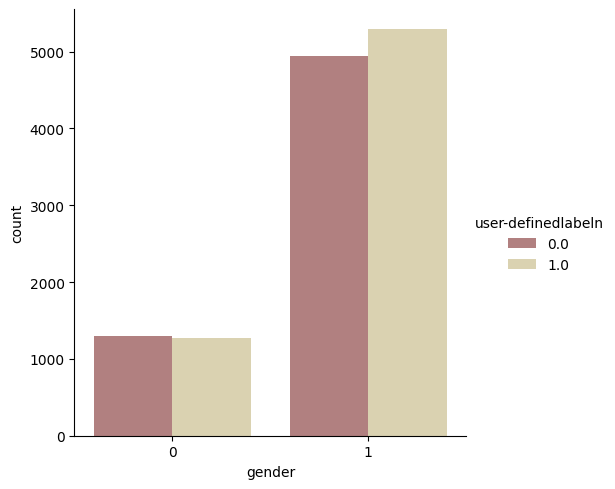

In [9]:
sns.catplot(x="gender", kind="count",hue = 'user-definedlabeln', palette="pink", data=data)

Please note that women are coded with the symbol "1"and men - "0". We can notice that ratio of confusion level in male is higher than that of women. It is safe to assume now that the confusin level in men will be more than in women.

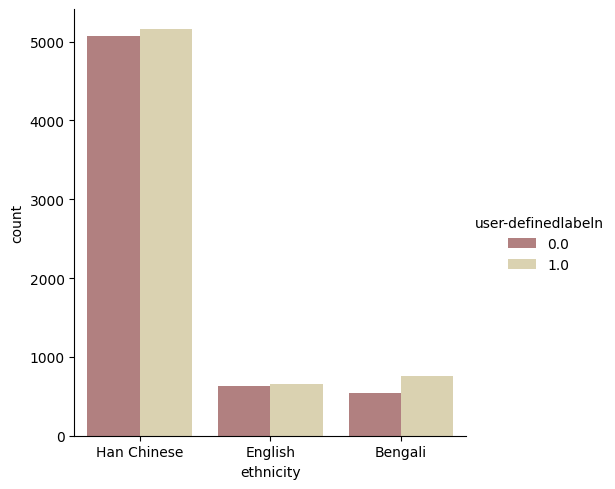

In [10]:
sns.catplot(x="ethnicity", kind="count",hue = 'user-definedlabeln', palette="pink", data=data)

Confusion level ratio in Bengali is noticeable.

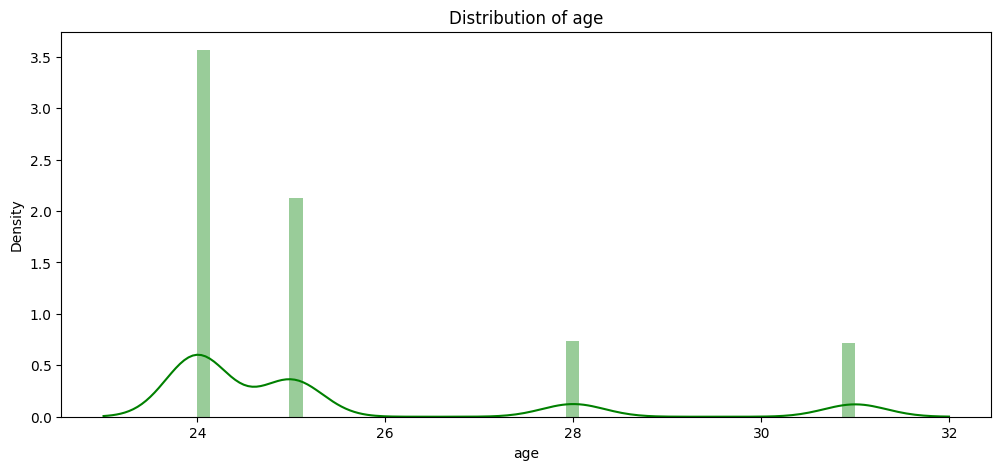

In [11]:
pl.figure(figsize=(12,5))
pl.title("Distribution of age")
ax = sns.distplot(data["age"], color = 'g')

Since it's EEG signal data from 10 students, variance in individual is limited. However, I want to know if there is difference in between ages, given the confusion level.

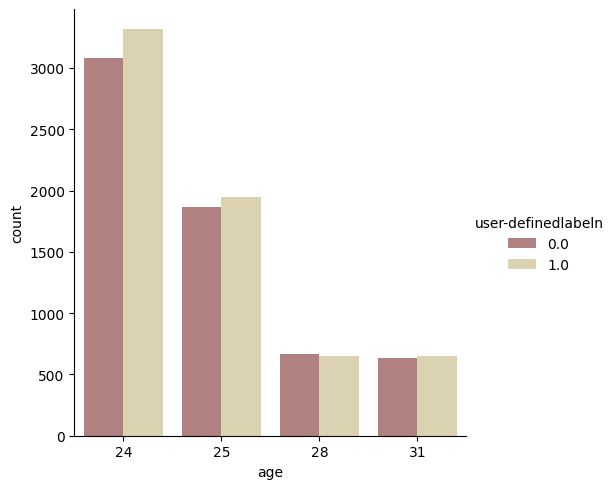

In [12]:
sns.catplot(x="age", kind="count",hue = 'user-definedlabeln', palette="pink", data=data)

I see that younger students' confusion level is higher than the older.
Let's do some more analysis for numeric columns.

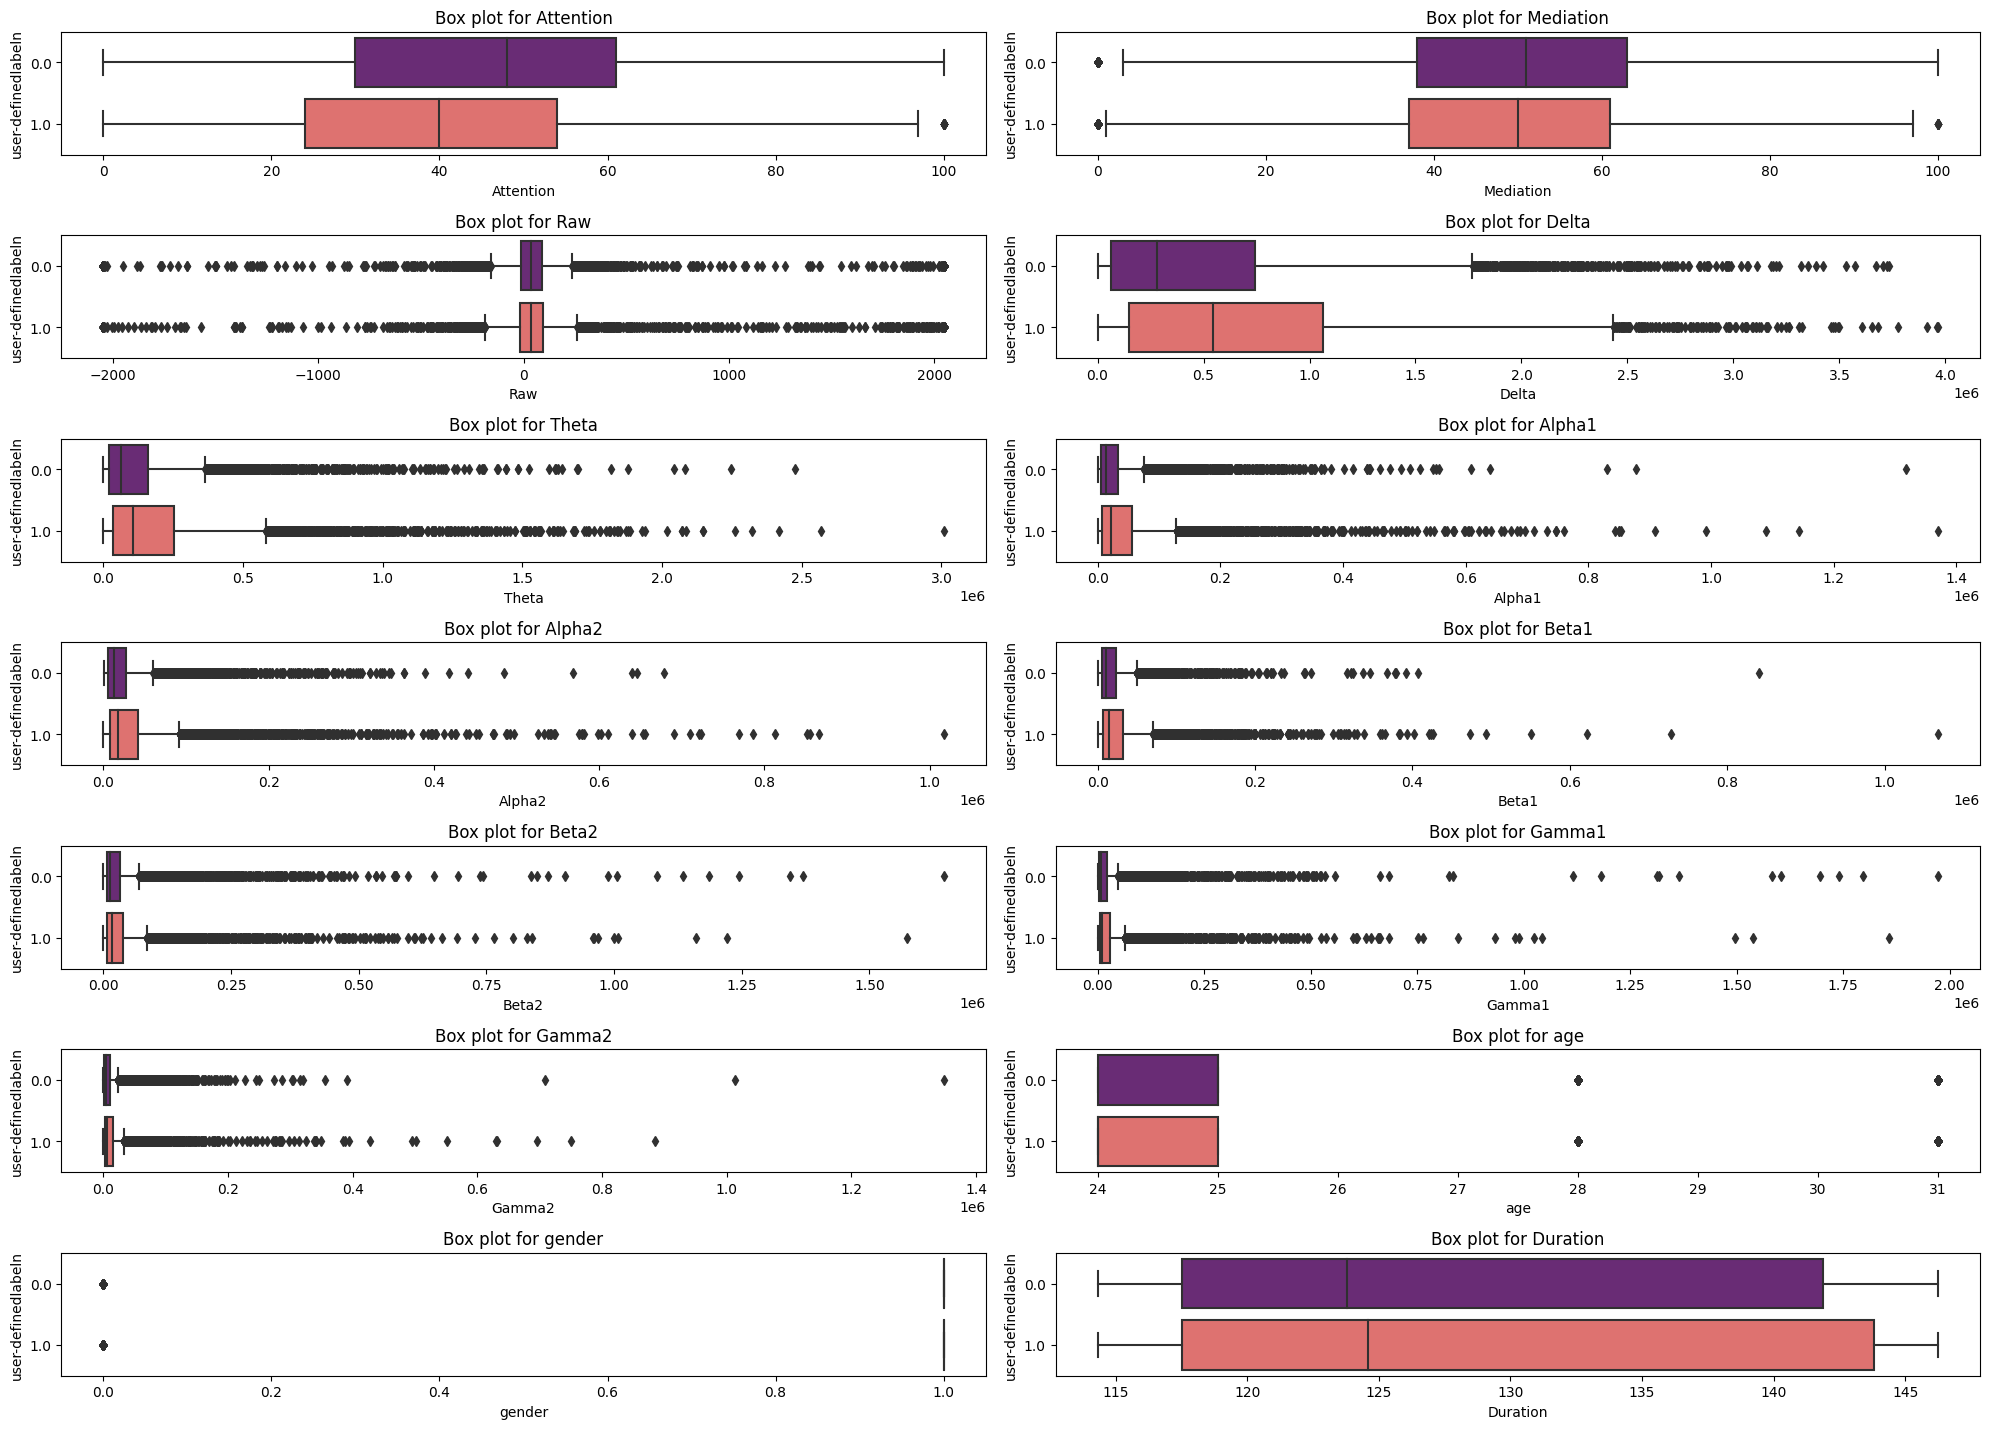

In [13]:
# Select only numeric columns
numeric_cols = data.select_dtypes(include=['number'])

# Create a box plot for each numeric column
pl.figure(figsize=(20, 16))
pl.subplots_adjust(hspace=1)
for i, column in enumerate(numeric_cols.columns, 1):
    pl.subplot(8, 2, i)
    pl.title(f"Box plot for {column}")
    sns.boxplot(y="user-definedlabeln", x=numeric_cols[column], data = data, orient="h", palette = 'magma')

pl.tight_layout()
pl.show()

Attention and Delta signal data are the top two significant variables given in above plots.
Let's visulize Attention and Delta distribution of men and women.

Text(0.5, 1.0, 'Distribution of delta and attention for men')

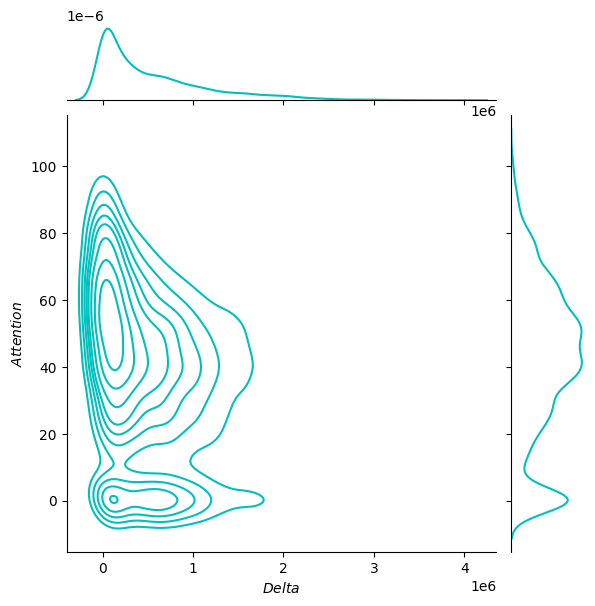

In [14]:
g = sns.jointplot(x="Delta", y="Attention", data = data[(data.gender == 1)], kind="kde", color="c")
g.plot_joint(pl.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Delta$", "$Attention$")
ax.set_title('Distribution of delta and attention for men')

Text(0.5, 1.0, 'Distribution of delta and attention for women')

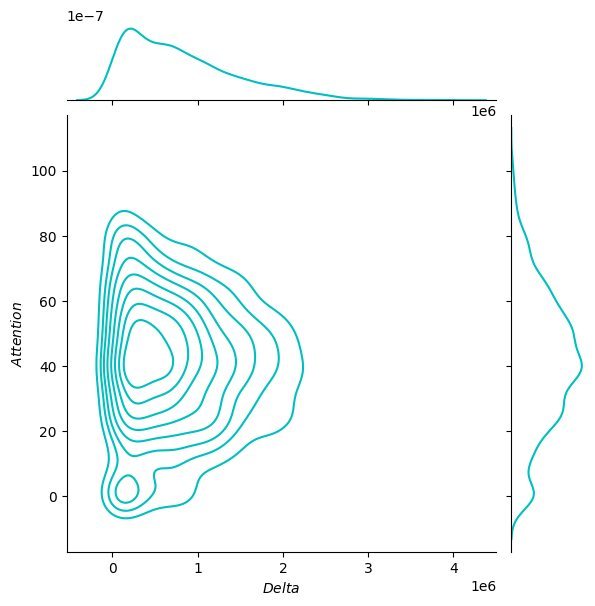

In [15]:
g = sns.jointplot(x="Delta", y="Attention", data = data[(data.gender == 0)], kind="kde", color="c")
g.plot_joint(pl.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Delta$", "$Attention$")
ax.set_title('Distribution of delta and attention for women')

Clearly, men and women are showing difference in distribution of Attention and Delta.
Let's move on to the statistical analysis.

### 3-2) Statistical data analysis  
Let's do One hot encoding : make categorical columns to 0 and 1

In [16]:
data = pd.get_dummies(data, columns=['ethnicity'])

#### 3-2a. Correlation and Heatmap

In [17]:
pd.DataFrame(abs(data.corr()['user-definedlabeln']).sort_values(ascending = False))

,user-definedlabeln
user-definedlabeln,1.000000
Delta,0.148588
Theta,0.147558
Alpha1,0.121711
Attention,0.119088
Beta1,0.111482
Alpha2,0.107238
Duration,0.070605
Gamma2,0.053533
ethnicity_Bengali,0.048270


Delta is the most important correlated feature with Confustion Level followed by Theta.  
In statistics, the Pearson correlation coefficient is a correlation coefficient that measures linear correlation between two sets of data.  
It is the ratio between the covariance of two variables and the product of their standard deviations;  
This coefficient ranges from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no linear correlation.  
##### **Here, we can say that Delta and Theta has little correlation with Confustion level.**

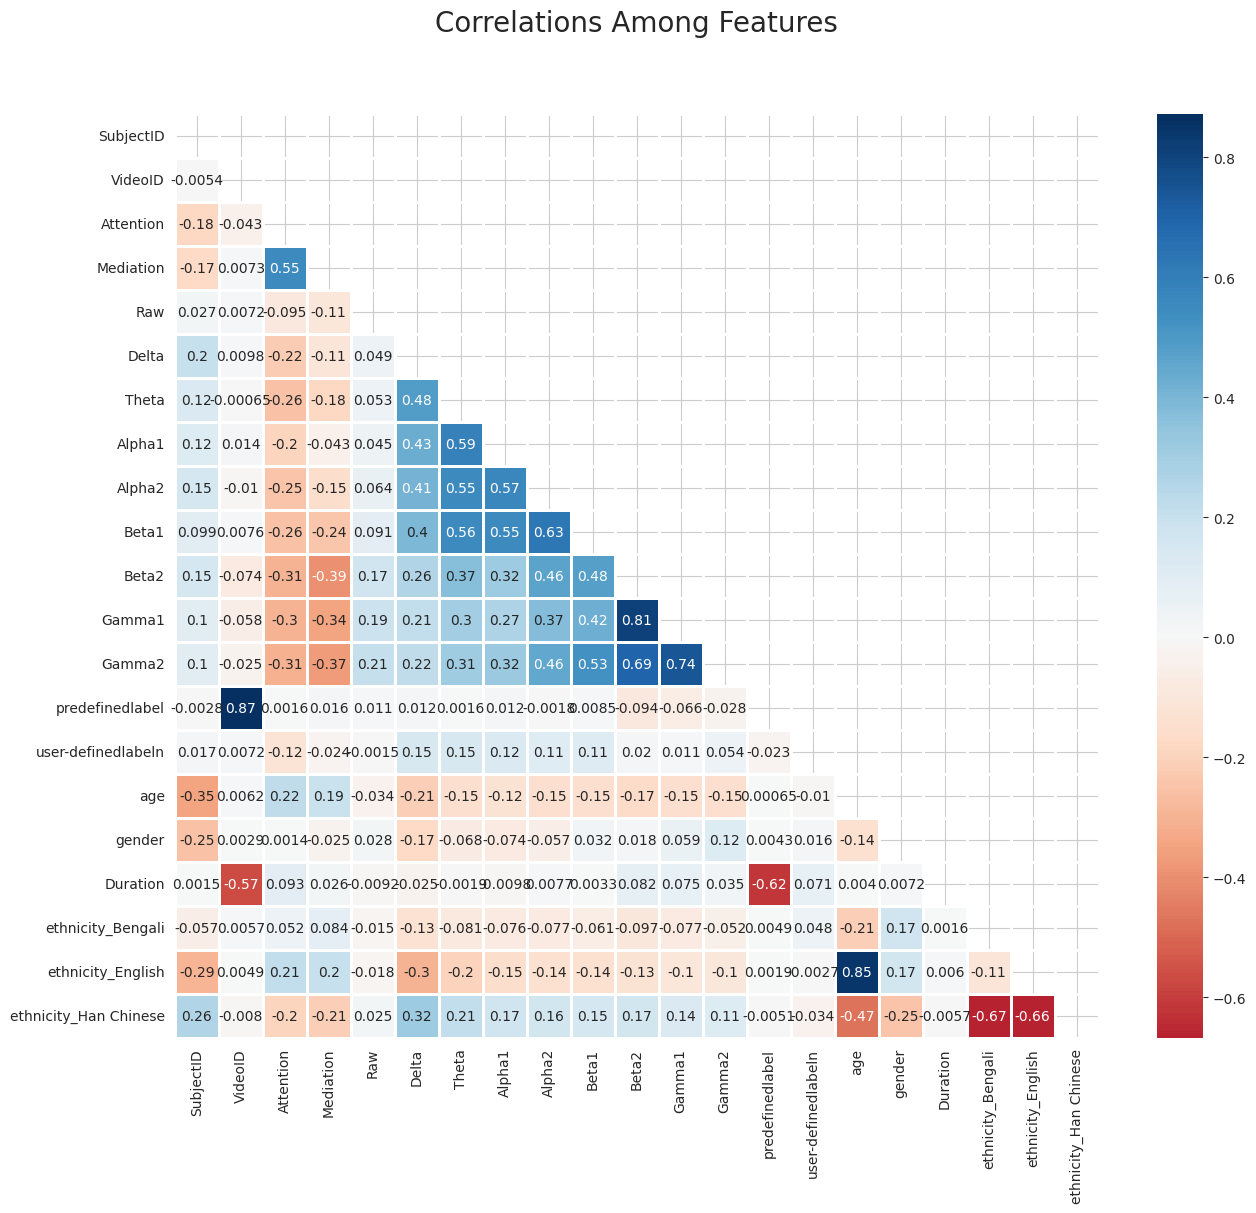

In [18]:
## heatmeap to see the correlation between features. 
# Generate a mask for the upper triangle (taken from seaborn example gallery)

mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set_style('whitegrid')
pl.subplots(figsize = (15,12))
sns.heatmap(data.corr(), 
            annot=True,
            mask = mask,
            cmap = 'RdBu', ## in order to reverse the bar replace "RdBu" with "RdBu_r"
            linewidths=.9, 
            linecolor='white',
            fmt='.2g',
            center = 0,
            square=True)
pl.title("Correlations Among Features", y = 1.03,fontsize = 20, pad = 40);

*Positive Correlation Features:*  
* Delta and Ethnicity_Chinese: 0.32    

*Negative Correlation Features:*
* Age and Ethnicity_Chinese: -0.6  

So, Let's analyze these correlations a bit. We have found some relationships between different features.   
There is a positive correlation between Delta signal and Chinese ethnicity.  
This relationship reveals that the chinese students were more likely to have higher Delta signal.  
But the correlation between Chinese ethnicity and age, which is -0.6 is I think can be ignored because this can also be explained by saying that chinese students were just younger than the other ethnic students.

However, there is nothing we can say the most significant correlation with our confustion level variable.

Under the purpose of applying the hypothesis testing learned in school to real data, and let's select "Gender" as a significant variable and do some statistics to see how statistically correlated to each other.

#### 3-2b. Hypothesis Testing  
We want to answer this question: "Is there a substantial difference in the confusion level between the male and the female students?"

1. Define Null Hypothesis(𝐻0) and Alternative Hypothesis(𝐻𝐴).  
A null hypothesis is a type of hypothesis used in statistics that proposes that no statistical significance exists in a set of given observations. Thus, the null hypothesis is a hypothesis which people tries to disprove it. Alternative hypothesis is a hypothesis which people want to tries to prove it.

2. Compute p-value that is probablity of seeing the apparent effect if the null hypothesis is true.  
Suppose we have null hypothesis test. Then we calculate p value. If p value is less than or equal to a threshold, we reject null hypothesis.

> If the p-value is low, the effect is said to be statistacally significant that means that it is unlikely to have occured by chance. Therefore we can say that the effect is more likely to appear in the larger population.

In [19]:
group1 = data["gender"]
group2 = data["user-definedlabeln"]

# Calculate the means and variances for each group
mean1 = np.mean(group1)
mean2 = np.mean(group2)
var1 = np.var(group1, ddof=1)  # Use ddof=1 for sample variance
var2 = np.var(group2, ddof=1)

# Calculate the t-statistic
n1 = len(group1)
n2 = len(group2)
pooled_var = ((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2)
t_statistic = (mean1 - mean2) / np.sqrt(pooled_var * (1/n1 + 1/n2))

# Calculate the degrees of freedom
degrees_of_freedom = n1 + n2 - 2

# Assume a two-tailed test (you can adjust this based on your hypothesis)
alpha = 0.05 / 2  # Divide alpha by 2 for a two-tailed test

# Calculate the critical t-value for the given alpha
critical_value = t.ppf(1 - alpha, df=degrees_of_freedom)

# Calculate the p-value
p_value = 2 * (1 - t.cdf(np.abs(t_statistic), df=degrees_of_freedom))

# Determine whether to reject the null hypothesis
if p_value < alpha:
    print(f"Reject the null hypothesis (p-value = {p_value}, t-statistic = {t_statistic})")
else:
    print(f"Fail to reject the null hypothesis (p-value = {p_value}, t-statistic = {t_statistic})")

print('p-value: ',p_value)

Reject the null hypothesis (p-value = 0.0, t-statistic = 50.59581959507524)
p-value:  0.0


**It is weird that p-value came out to be 0.0 but the correlation value is 0.016.**

A p-value of 0.0 indicates an extremely low probability of observing the data if the null hypothesis were true. It means that the data you have observed is highly inconsistent with the null hypothesis. In most practical cases, a p-value of 0.0 is not truly zero but rather rounded to zero due to the precision of calculations. It suggests strong evidence against the null hypothesis.

On the other hand, a correlation value of 0.016 is very close to zero, indicating a very weak linear relationship between the two variables. In statistical terms, a correlation value close to zero suggests that there is little to no linear association between the variables. The relationship, if any, is negligible.

In this context: Considering not only the statistical significance (p-value) but also the practical significance (effect size) and the context of the data when interpreting the results, a statistically significant but very weak relationship may not have much practical importance.

## 4. Train Model and Analyze the Results

### 4-1) Split Data

Before we apply any machine learning models, It is important to separate dependent and independent variables. Our dependent variable or target variable is something that we are trying to find, and our independent variable is the features we use to find the dependent variable.

In [20]:
data.drop(columns = ['SubjectID','VideoID','predefinedlabel'], inplace=True)

# separating our independent and dependent variable
X = data.drop(['user-definedlabeln'], axis = 1)
y = data['user-definedlabeln'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .33, random_state=0)

### 4-2) Scaling  
Let's standardize the data. In this context, data standardization means converting data values to have mean of 0 and a standard deviation of 1.

In [21]:
scaler = StandardScaler()

## transforming "train_x"
X_train = scaler.fit_transform(X_train)

## transforming "test_x"
X_test = scaler.transform(X_test)

In [22]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-1.792104,-2.089686,3.337326,0.692948,-0.281419,0.054678,0.587749,0.947022,3.954719,1.049515,0.396992,-0.637986,0.494605,-0.352069,-0.339278,-0.340132,0.510791
1,0.407126,0.834719,0.187021,1.319067,3.487991,1.165768,2.045507,1.428299,-0.059562,-0.198595,0.006138,1.161351,-2.021813,1.576074,-0.339278,-0.340132,0.510791
2,0.924592,0.037154,-0.047021,1.109966,-0.052406,0.832513,-0.318438,-0.363050,-0.150489,-0.282543,-0.332234,-0.637986,0.494605,-0.216635,-0.339278,-0.340132,0.510791
3,2.002645,0.170082,0.045585,-0.940819,-0.617888,-0.512766,-0.478370,-0.420431,0.129334,-0.168445,0.836098,-0.188152,0.494605,1.187594,-0.339278,-0.340132,0.510791
4,1.442057,0.303009,-0.129525,-0.617414,-0.205297,-0.374587,-0.515869,-0.200380,-0.412149,-0.315997,-0.181238,-0.188152,0.494605,1.187594,-0.339278,-0.340132,0.510791


In [23]:
pd.DataFrame(X_test).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.325951,0.170082,-0.095850,0.752395,-0.157942,0.172796,-0.500387,-0.391306,-0.082926,-0.168802,-0.309126,-0.188152,0.494605,1.187594,-0.339278,-0.340132,0.510791
1,-0.800294,-0.140083,-0.111004,2.289409,0.215100,0.611730,-0.238225,0.120752,0.019721,-0.143862,-0.215848,1.161351,-2.021813,1.187594,-0.339278,-0.340132,0.510791
2,2.088890,0.834719,-0.547097,-0.511082,-0.483252,0.112544,-0.475006,-0.472392,-0.279325,-0.273943,-0.345057,-0.637986,0.494605,1.187594,-0.339278,-0.340132,0.510791
3,1.183324,-0.760411,0.003491,-0.168683,-0.172525,-0.446240,-0.200955,0.087050,-0.186034,-0.125027,-0.229675,-0.188152,0.494605,-1.268025,-0.339278,-0.340132,0.510791
4,1.226447,-0.317319,-0.072278,0.509077,-0.408314,-0.402367,-0.500387,-0.012978,0.380002,0.115798,0.190209,-0.188152,0.494605,-0.423349,-0.339278,-0.340132,0.510791


You can see how the features have transformed above.

### 4-3) Modeling

#### 4-3a. Linear Regression

In [24]:
# call on the model object
lr = LogisticRegression(solver='liblinear',
                        penalty= 'l1',
                        random_state = 42                                
                        )

# fit the model with "train_x" and "train_y"
lr.fit(X_train, y_train)

# Once the model is trained we want to find out how well the model is performing, so we test the model. 
# we use "X_test" portion of the data(this data was not used to fit the model) to predict model outcome. 
y_pred = lr.predict(X_test)

# Once predicted we save that outcome in "y_pred" variable.
# Then we compare the predicted value( "y_pred") and actual value("test_y") to see how well our model is performing.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59      2089
           1       0.60      0.63      0.62      2139

    accuracy                           0.60      4228
   macro avg       0.60      0.60      0.60      4228
weighted avg       0.60      0.60      0.60      4228



#### 4-3b. LightGBM

In [25]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'num_leaves': [15, 31, 50],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid = GridSearchCV(estimator=lgb.LGBMClassifier(**param_grid),
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=3)
grid.fit(X_train, y_train)

best_params = grid.best_params_
print("Best Hyperparameters:", best_params)

# Train the Model with Tuned Hyperparameters
best_lgb = lgb.LGBMClassifier(**best_params)
tuned_bst = best_lgb.fit(X_train, y_train)

# Make Predictions
y_pred = tuned_bst.predict(X_test)
y_pred_binary = np.round(y_pred)

# Evaluate the model
print(classification_report(y_test, y_pred_binary))

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 5, 'num_leaves': 15}
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      2089
           1       0.87      0.92      0.89      2139

    accuracy                           0.89      4228
   macro avg       0.89      0.89      0.89      4228
weighted avg       0.89      0.89      0.89      4228



In [26]:
order = [13, 11, 0, 9, 10, 6, 2, 7, 12, 8]
importance_cols = []
for i, col in enumerate(X.columns):
    for j in order:
        if i == j:
            importance_cols.append(col)
            print(f"Column_{i}:", col)

Column_0: Attention
Column_2: Raw
Column_6: Alpha2
Column_7: Beta1
Column_8: Beta2
Column_9: Gamma1
Column_10: Gamma2
Column_11: age
Column_12: gender
Column_13: Duration


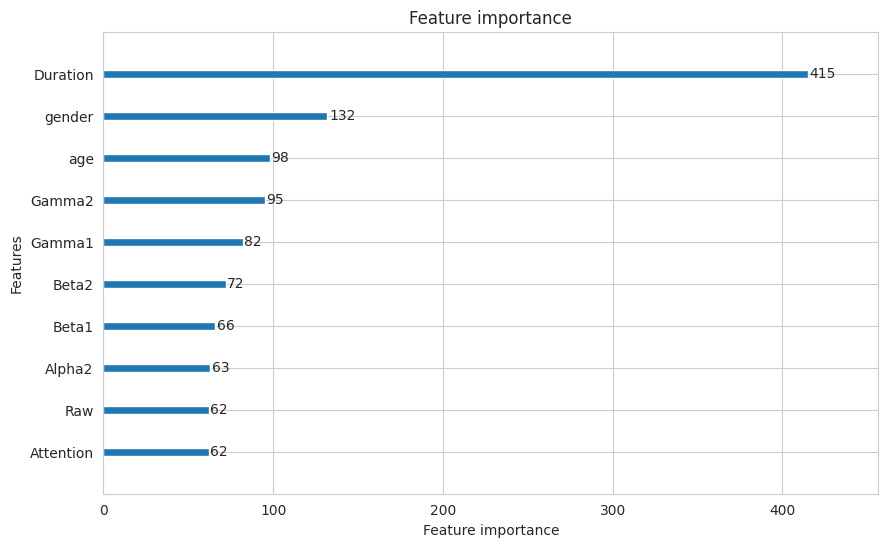

In [27]:
# tuned_bst.feature_importances_
fig, ax = pl.subplots(figsize=(10, 6))
lgb.plot_importance(tuned_bst, max_num_features=10, ax=ax)
ax.set_yticklabels(importance_cols)
pl.show()

These are the top 10 features determined by LightGBM(Tree based model) helped classifing the confustion level of each students.

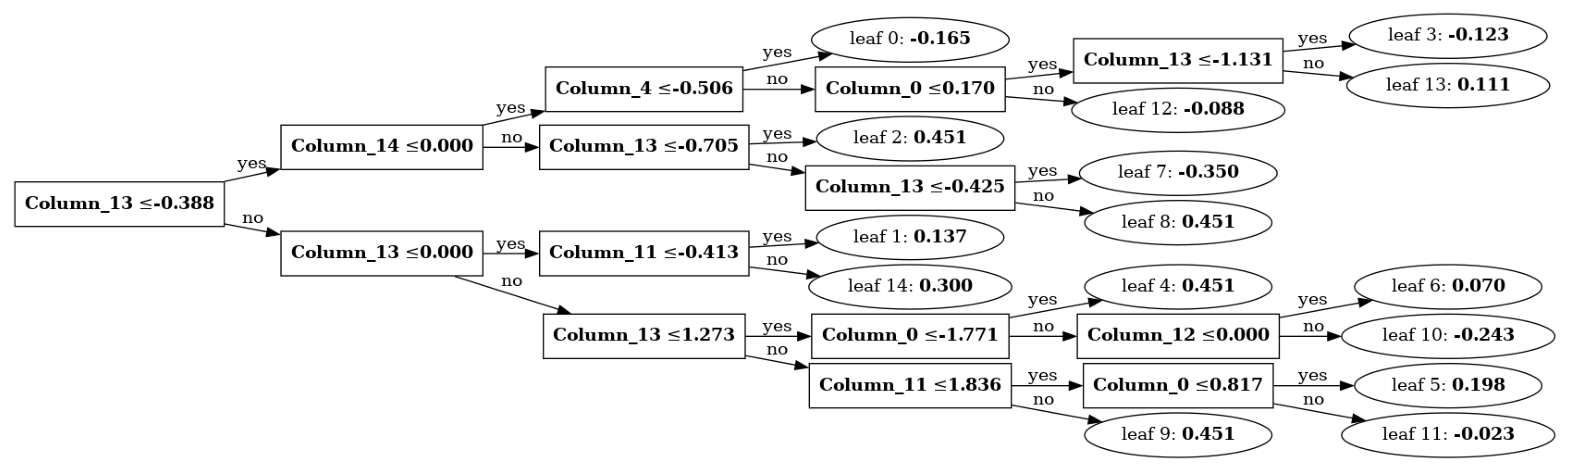

In [28]:
tree_index = 0
lgb.plot_tree(tuned_bst, tree_index=tree_index, figsize=(20, 10))
pl.show()

* Column_0: Attention
* Column_2: Raw
* Column_6: Alpha2
* Column_7: Beta1
* Column_8: Beta2
* Column_9: Gamma1
* Column_10: Gamma2
* Column_11: age
* Column_12: gender
* Column_13: Durationa

**The Duration feature is a dominant feature when LightGBM makes decision whether each student is confused or not.**